# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<b>Описание данных</b>

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

<b>План работы:</b><br>
- Загрузим и подготовим данные.
- Обучим и проверим модель для каждого региона.
- Рассчитаем прибыль по выбранным скважинам и предсказаниям модели. 
- Посчитаем риски и прибыль для каждого региона.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
BUDGET = 10_000_000_000 # Бюджет на разработку скважин в регионе
PRICE = 450_000 # Доход с каждой единицы продукта
COUNT = 200 # Количество скважин

Откроем файлы и изучим данные.

In [3]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
print(df_1.info())
display(df_1.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
print(df_2.info())
display(df_2.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [6]:
print(df_3.info())
display(df_3.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
display(df_1.head(3))
display(df_2.head(3))
display(df_3.head(3))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


Проверим данные на пропуски.

In [8]:
df_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [9]:
df_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [10]:
df_3.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Проверим данные на явные дубликаты.

In [11]:
df_1.duplicated().sum()

0

In [12]:
df_2.duplicated().sum()

0

In [13]:
df_3.duplicated().sum()

0

Пропуски и явные дубликаты отсутствуют.

Удалим не информативные колонки с `id` скважин, для обучения модели эти признаки нам не нужны.

In [14]:
df_1.drop(columns=['id'], axis = 1, inplace=True)
df_2.drop(columns=['id'], axis = 1, inplace=True)
df_3.drop(columns=['id'], axis = 1, inplace=True)

In [15]:
df_1.head(2)

,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.280062
1,1.334711,-0.340164,4.36508,73.037750


Проведем корреляционный анализ данных. Посмотрим как признаки взаимосвязаны друг с другом.

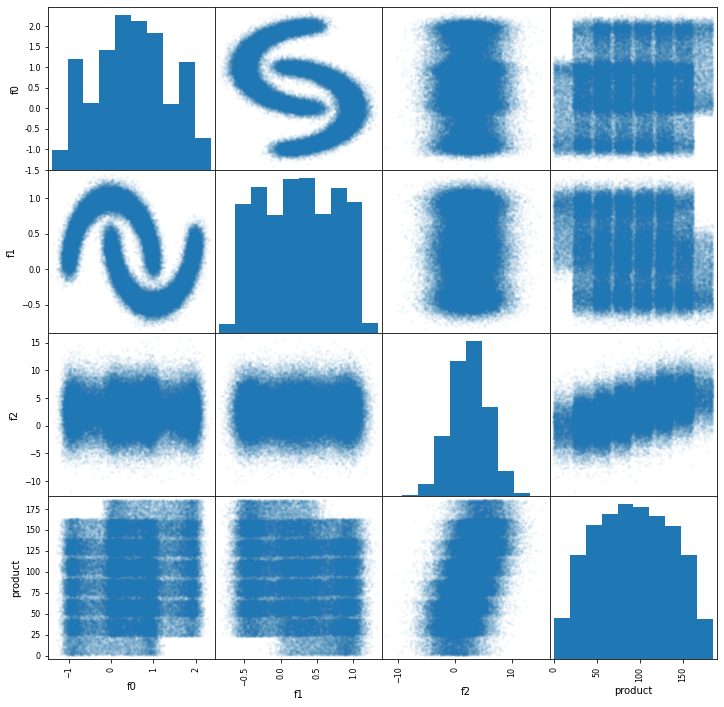

In [16]:
_ = pd.plotting.scatter_matrix(df_1, figsize=(12, 12), alpha=0.05)

In [17]:
df_1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


**Первый регион.** В таблице коэффициентов корреляции можно увидеть, что у признаков f0 и f1 есть маленькая положительная и отрицательная взаимосвязь с таргет признаком. У f2 средняя положительная.

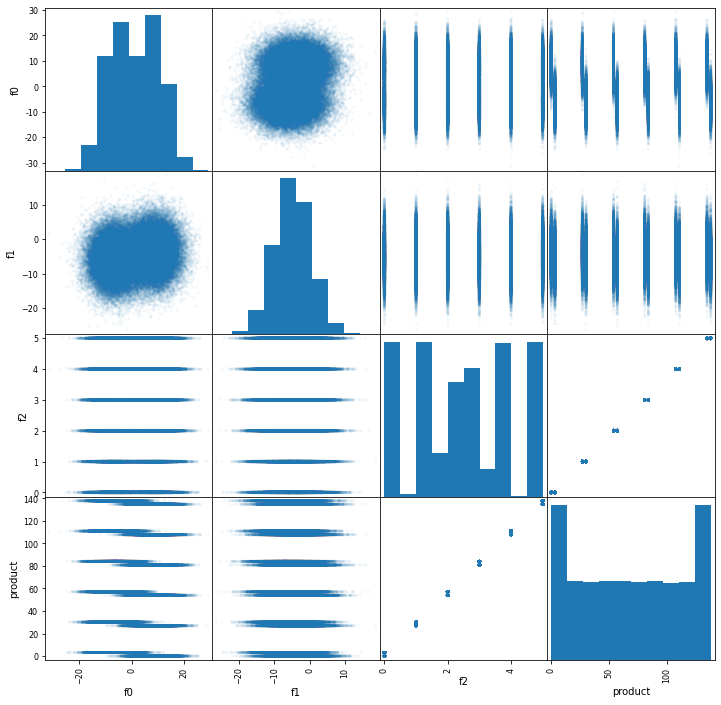

In [18]:
_ = pd.plotting.scatter_matrix(df_2, figsize=(12, 12), alpha=0.05)

In [19]:
df_2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


**Второй регион.** Можно увидеть, что у признаков f0 и f1 практически отсутствует взаимосвязь с таргет признаком, а f2 имеет полную взаимосвязь с таргет признаком.<br>

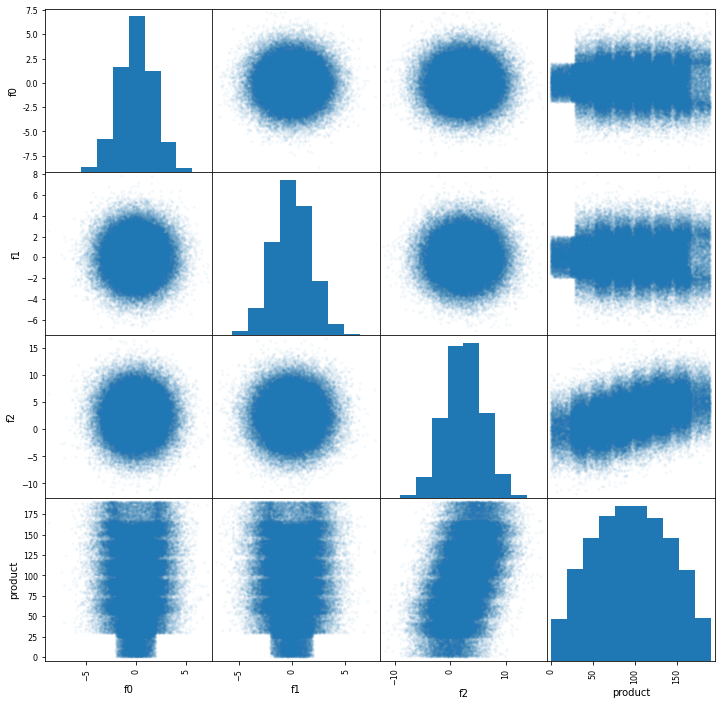

In [20]:
_ = pd.plotting.scatter_matrix(df_3, figsize=(12, 12), alpha=0.05)

In [21]:
df_3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Третий регион.** Аналогично второму у признаков f0 и f1 вообще отсутствует взаимосвязь с таргет признаком, а f2 имеет среднюю взаимосвязь с таргет признаком.<br>

p.s. тут аналогично - вообще не нужны признаки f0 и f1, целевой признак зависит только от признака f2.

Удалим малоинформативные признаки без взаимосвязи с таргет признаком.

In [22]:
df_2.drop(columns=['f0', 'f1'], axis = 1, inplace=True)
df_3.drop(columns=['f0', 'f1'], axis = 1, inplace=True)

In [23]:
df_2.head(3)

,f2,product
0,-0.005876,3.179103
1,0.999183,26.953261
2,5.001160,134.766305


### Краткий вывод

Загрузили и ознакомились с данными. Пропуски и явные дубликаты отсутствуют. Удалили не информативный признак - `id` скважины.

В первом регионе есть взаимосвязь всех общих признаков с целевым. Во втором и третьем регионе взаимосвязь таргет признака с признаками f0, f1 полностью отсутствует. Во втором регионе полная зависимость таргет признака с f2. В третьем регионе имеем среднюю взаимосвязь таргет признака с f2.

Удалили малоинформативные признаки без взаимосвязи с таргет признаком.

## Обучение и проверка модели

Разделим данные по признакам - общие и целевые.

In [24]:
features_1, target_1 = df_1.drop('product', axis=1), df_1['product']
features_2, target_2 = df_2.drop('product', axis=1), df_2['product']
features_3, target_3 = df_3.drop('product', axis=1), df_3['product']

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [25]:
features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=33)

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=33)

features_3_train, features_3_valid, target_3_train, target_3_valid = train_test_split(
    features_3, target_3, test_size=0.25, random_state=33)

In [26]:
features_1_train.head(3)

,f0,f1,f2
26206,-0.544311,1.013703,1.514376
55295,1.350665,-0.424232,1.322846
74722,-0.119028,0.218603,-1.003023


Обучим модель линейной регрессии и сделаем предсказания на валидационной выборке.

Напишем функцию для рассчета и вывода среднего запаса предсказанного сырья и RMSE. Функция возвращает предсказания на валидационной выборке.

In [27]:
def print_mean_rmse(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = pd.Series(model.predict(features_valid))
    mse_1 = mean_squared_error(target_valid, predicted_valid)

    print('Mean predict product =', predicted_valid.mean())
    print('RMSE =', mse_1 ** 0.5)
    return predicted_valid

Сделаем рассчеты среднего запаса предсказанного сырья и RMSE для 1 региона:

In [28]:
predicted_valid_1 = print_mean_rmse(
    features_1_train, target_1_train,
    features_1_valid, target_1_valid)

Mean predict product = 92.85835849094728
RMSE = 37.692408112930075


Для 2 региона:

In [29]:
predicted_valid_2 = print_mean_rmse(
    features_2_train, target_2_train,
    features_2_valid, target_2_valid)

Mean predict product = 68.89494156378467
RMSE = 1.5953906618660252


И 3 регион:

In [30]:
predicted_valid_3 = print_mean_rmse(
    features_3_train, target_3_train,
    features_3_valid, target_3_valid)

Mean predict product = 95.10992871432467
RMSE = 40.18638000287447


### Краткий вывод

Как видим 3 регион имеет самый большой средний предсказанный объем сырья - 95.1 тыс. барр., 1 регион немного меньше - 92.9 тыс. барр., а 2 регион имеет намного меньший объем сырья - 68.9 тыс. барр.<br>
1 и 3 регионы имеют почти одинаковый RMSE(квадратный корень из средней квадратичной ошибки) - 37.7 и 40.2 соответственно, а во 2 регионе имеем очень маленький показатель метрики RMSE - 1.59<br>

## Подготовка к расчёту прибыли

In [31]:
min_capacity = round(BUDGET / PRICE / COUNT, 2)
print('Минимальный объём сырья для безубыточной разработки новой скважины:', min_capacity)

Минимальный объём сырья для безубыточной разработки новой скважины: 111.11


Сравним нужный объём сырья со средним запасом в каждом регионе.

In [32]:
mean_data = (
    {'min_capacity': [min_capacity],
     'mean_geo_1': [round(predicted_valid_1.mean(), 2)],
     'mean_geo_2': [round(predicted_valid_2.mean(), 2)],
     'mean_geo_3': [round(predicted_valid_3.mean(), 2)]}
)
display(pd.DataFrame(data=mean_data))

,min_capacity,mean_geo_1,mean_geo_2,mean_geo_3
0,111.11,92.86,68.89,95.11


### Краткий вывод

Первый и третий регион имеют среднее объема сырья немного меньше нужного объема для безубыточной разработки скважин. Во втором регионе среднее намного меньше нужного объема. Из этого можно сделать вывод, что 1-й и 3-й регионы более перспективные.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта выручки по выбранным скважинам и предсказаниям модели.

In [33]:
def revenue(target, predicted, COUNT):
    predict_sorted = predicted.sort_values(ascending=False)
    selected = target[predict_sorted.index][:COUNT]
    return round(PRICE * selected.sum())

Выберем нужное количества скважин с максимальными предсказаниями, подсчитаем объем сырья соответствующий этим предсказаниям и рассчитаем прибыль для полученного объема сырья.

In [34]:
target_1_valid = target_1_valid.reset_index(drop=True)
target_2_valid = target_2_valid.reset_index(drop=True)
target_3_valid = target_3_valid.reset_index(drop=True)

In [35]:
revenue_geo_1 = revenue(target_1_valid, predicted_valid_1, COUNT)
print('Прибыль в 1 регионе:', revenue_geo_1 - BUDGET)

Прибыль в 1 регионе: 3296550038


In [36]:
revenue_geo_2 = revenue(target_2_valid, predicted_valid_2, COUNT)
print('Прибыль в 2 регионе:', revenue_geo_2 - BUDGET)

Прибыль в 2 регионе: 2251998734


In [37]:
revenue_geo_3 = revenue(target_3_valid, predicted_valid_3, COUNT)
print('Прибыль в 3 регионе:', revenue_geo_3 - BUDGET)

Прибыль в 3 регионе: 2756325230


In [38]:
data=({'Регион 1': [revenue_geo_1 - BUDGET],
       'Регион 2': [revenue_geo_2 - BUDGET],
       'Регион 3': [revenue_geo_3 - BUDGET]})
all_rev = pd.DataFrame(data=data)
display(all_rev)

,Регион 1,Регион 2,Регион 3
0,3296550038,2251998734,2756325230


Максимальную прибыль показывает 1 регион - 3.30 млрд. руб., потом идет 3 регион - 2.76 млрд. руб. и 2 регион - 2.25 млрд. руб.

Посчитаем риски и прибыль для каждого региона. Применим технику Bootstrap, чтобы найти распределение прибыли.

Напишем формулу для поиска распределения прибыли по технике Bootstrap.

In [39]:
state = np.random.RandomState(33)

In [40]:
def get_values(target, predict):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, random_state=state, replace=True)
        predict_subsample = predict[target_subsample.index]
        values.append(revenue(target, predict_subsample, COUNT) - BUDGET)
    return values

Напишем функцию для рассчетов, которая будет выводить среднюю прибыль, 95%-й доверительные интервал и риск убытков.

In [41]:
def print_values_info(target, predicted):
    values = pd.Series(get_values(target, predicted))

    lower = round(values.quantile(0.025))
    upper = round(values.quantile(0.975))
    negative = (values < 0).sum() / len(values)

    print('Средняя прибыль:', round(values.mean()))
    print(f'95%-й доверительный интервал: {lower} - {upper}')
    print(f'Риск убытков: {negative :.1%}')

Произведем рассчеты для первого региона:

In [42]:
print_values_info(target_1_valid, predicted_valid_1)

Средняя прибыль: 471361075
95%-й доверительный интервал: -35228942 - 993116830
Риск убытков: 3.9%


Произведем рассчеты для второго региона:

In [43]:
print_values_info(target_2_valid, predicted_valid_2)


Средняя прибыль: 426494898
95%-й доверительный интервал: 23100368 - 813742662
Риск убытков: 1.9%


Произведем рассчеты для третьего региона:

In [44]:
print_values_info(target_3_valid, predicted_valid_3)

Средняя прибыль: 345473462
95%-й доверительный интервал: -153806660 - 828907588
Риск убытков: 10.5%


Наименьший риск убытков показал 2 регион - 0.8%, в этом регионе так же максимальная средняя прибыль - 506 млн. руб.

### Краткий вывод

Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

Выбрали нужное количества скважин с максимальными предсказаниями и подсчитали объем сырья и прибыль для полученного объема соответствующий этим предсказаниям.
Максимальную прибыль показал 1 регион - 3.30 млрд. руб., потом идет 3 регион - 2.76 млрд. руб. и 2 регион - 2.25 млрд. руб.

Посчитали риски и прибыль для каждого региона применяя технику Bootstrap, чтобы найти распределение прибыли.
Наименьший риск убытков показал 2 регион - 1.9% имея среднюю прибыль - 426 млн. руб.

## Вывод

Загрузили и ознакомились с данными. Пропуски и явные дубликаты отсутствуют. Удалили один не информативный признак.

В первом регионе есть взаимосвязь всех общих признаков с целевым. Во втором и третьем регионе взаимосвязь таргет признака с признаками f0, f1 полностью отсутствует. Во втором регионе полная зависимость таргет признака с f2. В третьем регионе имеем среднюю взаимосвязь таргет признака с f2.
Удалили малоинформативные признаки без взаимосвязи с таргет признаком.

3 регион имеет самый большой средний предсказанный объем сырья - 95.1 тыс. барр., 1 регион немного меньше - 92.9 тыс. барр., а 2 регион имеет намного меньший объем сырья - 68.9 тыс. барр.<br>
1 и 3 регионы имеют почти одинаковый RMSE(квадратный корень из средней квадратичной ошибки) - 37.7 и 40.2 соответственно, а во 2 регионе имеем очень маленький показатель метрики RMSE - 1.59<br>
Первый и третий регион имеют среднее объема сырья немного меньше нужного объема для безубыточной разработки скважин. Во втором регионе среднее намного меньше нужного объема. Из этого можно сделать вывод, что 1-й и 3-й регионы более перспективные.

Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.<br>
Выбрали нужное количества скважин с максимальными предсказаниями и подсчитали объем сырья и прибыль для полученного объема соответствующий этим предсказаниям.
Максимальную прибыль показал 1 регион - 3.30 млрд. руб., потом идет 3 регион - 2.76 млрд. руб. и 2 регион - 2.25 млрд. руб.

Посчитали риски и прибыль для каждого региона применяя технику Bootstrap, чтобы найти распределение прибыли.
Наименьший риск убытков показал 2 регион - 1.9% имея среднюю прибыль - 426 млн. руб.

Можно предложить второй регион для разработки скважин. Этот регион имеет вероятность убытков 1.9%, это единственный регион у которого она меньше 2.5%. Так же у него положительный 95%-й доверительный интервал: 23100368 - 813742662. Этот регион на втором месие по средней прибыли из трех представленных - 426 млн. руб.